In [4]:
!pip install praw pandas numpy matplotlib seaborn nltk textblob spacy gensim scikit-learn tensorflow transformers


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
pip install numpy==1.26.4

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install --upgrade tensorflow tensorflow_hub tensorflow_text


  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl (30 kB)
   ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
   -------------- ------------------------- 1.8/5.0 MB 9.1 MB/s eta 0:00:01
   ------------------------------- -------- 3.9/5.0 MB 9.0 MB/s eta 0:00:01
   ---------------------------------------- 5.0/5.0 MB 8.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/455.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/455.9 MB 10.1 MB/s eta 0:00:46
   ---------------------------------------- 2.6/455.9 MB 6.3 MB/s eta 0:01:13
   ---------------------------------------- 4.7/455.9 MB 7.7 MB/s eta 0:00:59
    --------------------------------------- 7.

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.25.0 requires toml<2,>=0.10.1, which is not installed.
spleeter 2.4.0 requires tensorflow<2.10.0,>=2.5.0, but you have tensorflow 2.10.1 which is incompatible.
streamlit 1.25.0 requires importlib-metadata<7,>=1.4, but you have importlib-metadata 7.0.1 which is incompatible.
streamlit 1.25.0 requires packaging<24,>=16.8, but you have packaging 24.1 which is incompatib

In [5]:
import pandas as pd
file_path = r'C:\Users\User\Downloads\SMA2\reddit_mental_health_dataset_fengg1.csv'
df = pd.read_csv(file_path)

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Data preparation - assuming df is your dataframe with 'clean_text' and 'disorder' columns
print("Initial Dataset Shape:", df.shape)
df.dropna(subset=['clean_text'], inplace=True)
print("After Dropping Missing Values:", df.shape)

# Encode disorders
encoder = LabelEncoder()
df['disorder_encoded'] = encoder.fit_transform(df['disorder'])
num_classes = len(encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(encoder.classes_)}")

# Balance dataset
balanced_df = []
for label in df['disorder_encoded'].unique():
    samples = df[df['disorder_encoded'] == label]
    balanced_samples = resample(samples, replace=True, n_samples=4000, random_state=42)
    balanced_df.append(balanced_samples)
df_balanced = pd.concat(balanced_df)
print("After Balancing Dataset:", df_balanced.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'], 
    df_balanced['disorder_encoded'],
    test_size=0.2, 
    random_state=42
)
print("Training Set Size:", len(X_train))
print("Test Set Size:", len(X_test))

# Convert labels to categorical for neural network
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# BERT model configuration
bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8"  # Smaller BERT for faster training
map_name_to_handle = {
    "small_bert/bert_en_uncased_L-4_H-512_A-8": "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
}
map_model_to_preprocess = {
    "small_bert/bert_en_uncased_L-4_H-512_A-8": "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
}

bert_model_handle = map_name_to_handle[bert_model_name]
bert_preprocess_handle = map_model_to_preprocess[bert_model_name]

# Build BERT-based model
def build_bert_model():
    # Input layer
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing & BERT encoder
    preprocessing_layer = hub.KerasLayer(bert_preprocess_handle, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(bert_model_handle, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Pooled output for classification
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)

    # Build model
    model = tf.keras.Model(inputs=text_input, outputs=net)

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=3e-5),
        loss=CategoricalCrossentropy(),
        metrics=[CategoricalAccuracy()]
    )

    return model


# Create the BERT model
print("Building BERT model...")
bert_model = build_bert_model()
print(bert_model.summary())

# Train the model
print("Training BERT model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

batch_size = 16  # Smaller batch size for BERT as it's memory intensive
history = bert_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=5,  # Fewer epochs as BERT converges faster
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
print("Evaluating BERT model...")
y_pred_prob = bert_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_decoded = y_test.values

# Calculate metrics
accuracy = accuracy_score(y_test_decoded, y_pred)
f1 = f1_score(y_test_decoded, y_pred, average='weighted')

print("\nBERT Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred, target_names=encoder.classes_))

# Create a prediction function for the BERT model
def predict_disorder_bert(text):
    # Get prediction probabilities
    prediction = bert_model.predict([text])[0]
    
    # Get top predictions
    top_indices = prediction.argsort()[-3:][::-1]
    results = []
    
    print("Top 3 predictions:")
    for idx in top_indices:
        disorder = encoder.classes_[idx]
        probability = prediction[idx] * 100
        results.append((disorder, probability))
        print(f"{disorder}: {probability:.2f}%")
    
    return results

# Save the model
try:
    bert_model.save('bert_mental_disorder_model')
    print("\nBERT model saved successfully!")
except Exception as e:
    print(f"\nCouldn't save BERT model: {e}")

# Example usage
print("\nTesting BERT model with sample text:")
sample_text = "I feel extremely anxious and worried all the time, I can't seem to control these feelings."
predict_disorder_bert(sample_text)

# Compare with the previous CNN model (if available)
try:
    cnn_predictions = predict_disorder(sample_text)
    print("\nCNN vs BERT comparison for sample text:")
    print("CNN predicted:", cnn_predictions)
    print("BERT predicted:", predict_disorder_bert(sample_text))
except:
    print("CNN model not available for comparison")

Initial Dataset Shape: (44559, 19)
After Dropping Missing Values: (44413, 19)
Number of classes: 12
Classes: ['ADHD', 'Anxiety', 'BPD', 'Bipolar', 'Depression', 'EatingDisorders', 'Normal', 'OCD', 'PTSD', 'Schizophrenia', 'Stress', 'SuicideWatch']
After Balancing Dataset: (48000, 19)
Training Set Size: 38400
Test Set Size: 9600
Building BERT model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'inpu

INFO:tensorflow:Assets written to: bert_mental_disorder_model\assets


INFO:tensorflow:Assets written to: bert_mental_disorder_model\assets



BERT model saved successfully!

Testing BERT model with sample text:
1/1 [==============================] - 0s 467ms/step
Top 3 predictions:
Anxiety: 54.77%
OCD: 32.67%
Stress: 7.08%
CNN model not available for comparison


In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Data preparation - assuming df is your dataframe with 'clean_text' and 'disorder' columns
# print("Initial Dataset Shape:", df.shape)
print("Initial Dataset Shape:", df.shape)
df.dropna(subset=['clean_text'], inplace=True)
print("After Dropping Missing Values:", df.shape)

# Encode disorders
encoder = LabelEncoder()
df['disorder_encoded'] = encoder.fit_transform(df['disorder'])
num_classes = len(encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {list(encoder.classes_)}")

# Balance dataset
balanced_df = []
for label in df['disorder_encoded'].unique():
    samples = df[df['disorder_encoded'] == label]
    balanced_samples = resample(samples, replace=True, n_samples=4000, random_state=42)
    balanced_df.append(balanced_samples)
df_balanced = pd.concat(balanced_df)
print("After Balancing Dataset:", df_balanced.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['clean_text'], 
    df_balanced['disorder_encoded'],
    test_size=0.2, 
    random_state=42
)
print("Training Set Size:", len(X_train))
print("Test Set Size:", len(X_test))

# Convert labels to categorical for neural network
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

Initial Dataset Shape: (44413, 19)
After Dropping Missing Values: (44413, 19)
Number of classes: 12
Classes: ['ADHD', 'Anxiety', 'BPD', 'Bipolar', 'Depression', 'EatingDisorders', 'Normal', 'OCD', 'PTSD', 'Schizophrenia', 'Stress', 'SuicideWatch']
After Balancing Dataset: (48000, 19)
Training Set Size: 38400
Test Set Size: 9600


In [3]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
sample_text = "I am in one of the top 20 NITs, tried so hard to get here only to end my life in the upcoming 10 days.I have totally lost the hope to live, even the thought of all my problems being solved still I would choose to end my life.I was never this negative during my JEE days,I'm a 3rd year mechanical student.I had already decided that i wound hang my self today but i didn't know today's holiday and I wont be alone in my room.It will be all over on Monday when my roomates will be gone to their classes and I'll be alone in my room. Something keeps happening as the D day comes closer today It was a holiday.It happened 3 times that something stopped me from doing it. It only happens when the decided dates comes closer"
predict_disorder_bert(sample_text)


1/1 [==============================] - 1s 997ms/step
Top 3 predictions:
SuicideWatch: 50.13%
Depression: 44.90%
BPD: 2.30%


[('SuicideWatch', 50.13280510902405),
 ('Depression', 44.895875453948975),
 ('BPD', 2.296825870871544)]

In [8]:
import numpy as np
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import tensorflow_hub as hub
import tensorflow_text as text  # required to load preprocessing layer

# Reload the saved model (must have tensorflow_text and tensorflow_hub imported)
print("Loading saved BERT model...")
bert_model = load_model("bert_mental_disorder_model", custom_objects={'KerasLayer': hub.KerasLayer})
print("Model loaded successfully!")

# Recompute prediction probabilities
y_pred_prob = bert_model.predict(X_test, batch_size=16)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_decoded = y_test.values


Loading saved BERT model...
Model loaded successfully!
600/600 [==============================] - 660s 1s/step


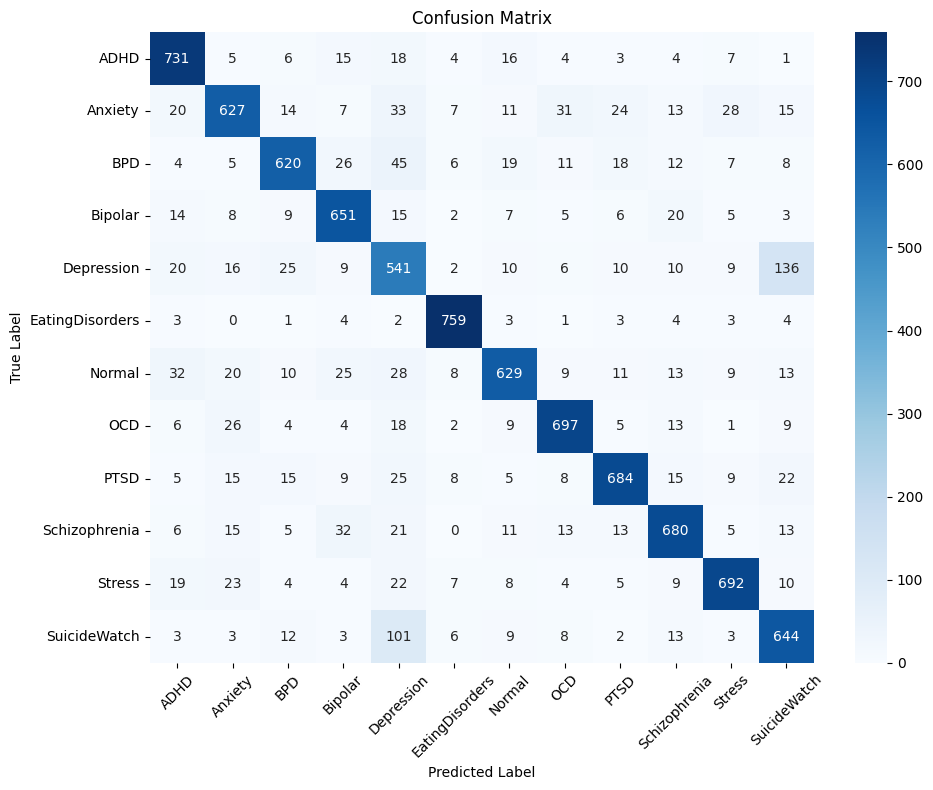

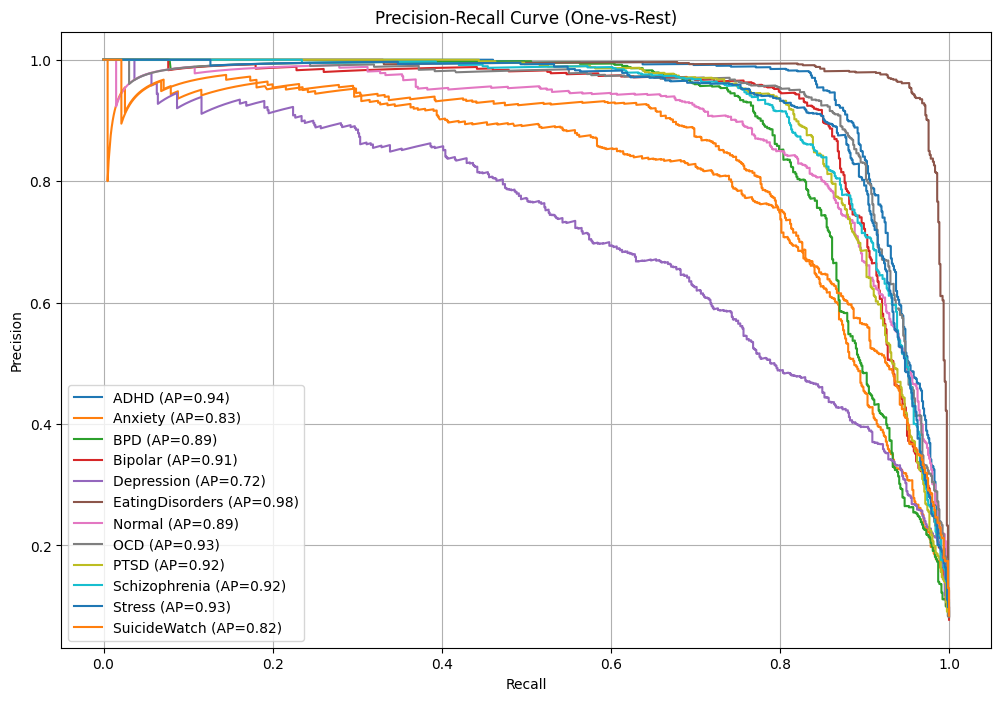

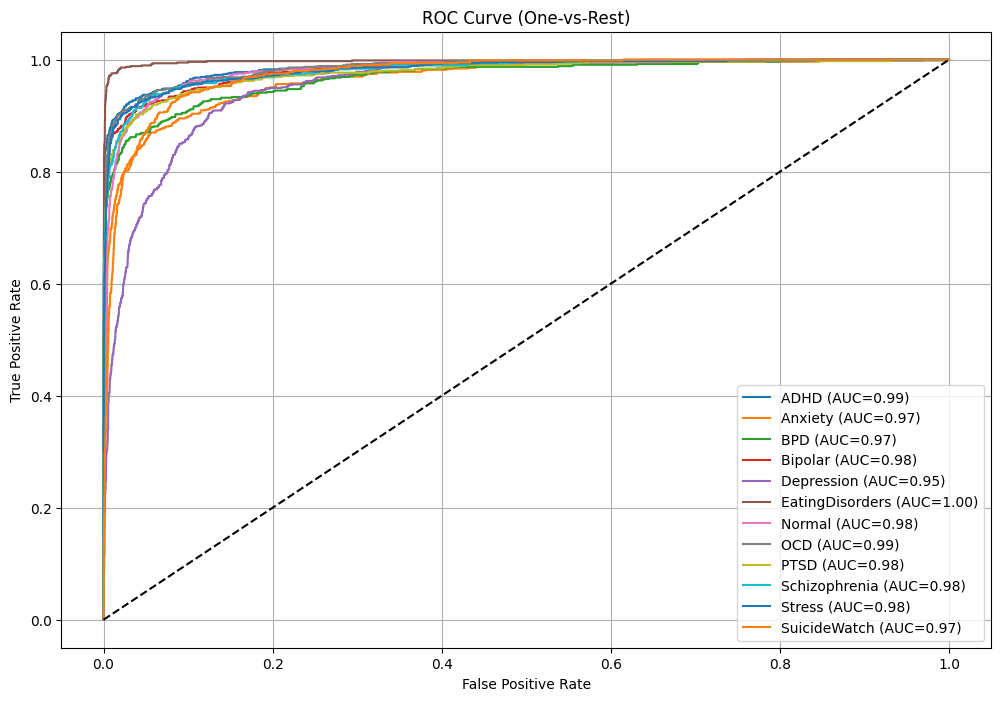

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_curve, auc, 
    precision_recall_curve, average_precision_score
)

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_decoded, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Binarize labels
y_test_bin = label_binarize(y_test_decoded, classes=list(range(num_classes)))

# Precision-Recall Curve (One-vs-Rest)
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f"{encoder.classes_[i]} (AP={ap_score:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

# ROC Curve (One-vs-Rest)
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{encoder.classes_[i]} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()


In [8]:
pip install matplotlib==3.7.1


   ---------------------------------------- 0.0/7.6 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/7.6 MB 10.1 MB/s eta 0:00:01
   --------------- ------------------------ 2.9/7.6 MB 7.0 MB/s eta 0:00:01
   --------------------- ------------------ 4.2/7.6 MB 7.9 MB/s eta 0:00:01
   ------------------------------- -------- 6.0/7.6 MB 7.2 MB/s eta 0:00:01
   -------------------------------------- - 7.3/7.6 MB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 7.6/7.6 MB 6.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
from ipywidgets import widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def create_interactive_bert_tool(model, encoder):
    """
    Create an interactive text classification tool using the trained BERT model.
    """
    print("Creating interactive BERT prediction tool...")

    # Create widgets
    text_input = widgets.Textarea(
        value='',
        placeholder='Enter text to classify...',
        description='Input:',
        disabled=False,
        layout={'width': '100%', 'height': '100px'}
    )

    analyze_button = widgets.Button(
        description='Analyze',
        button_style='success',
        tooltip='Click to analyze the text'
    )

    output = widgets.Output()

    def on_button_click(b):
        with output:
            clear_output()
            input_text = text_input.value.strip()
            if not input_text:
                print("Please enter some text first!")
                return

            # Predict using BERT
            prediction = model.predict([input_text])[0]
            sorted_indices = prediction.argsort()[::-1]

            # Visualize top predictions
            plt.figure(figsize=(10, 6))
            classes = [encoder.classes_[i] for i in sorted_indices]
            probs = [prediction[i] * 100 for i in sorted_indices]

            bars = plt.bar(classes, probs, color='skyblue')
            plt.xlabel('Disorder')
            plt.ylabel('Probability (%)')
            plt.title('Prediction Probabilities')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()

            # Annotate bar values
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.1f}%', ha='center', va='bottom')

            plt.show()

            # Print top 3 predictions
            print("Top 3 predictions:")
            for i in range(min(3, len(sorted_indices))):
                idx = sorted_indices[i]
                label = encoder.classes_[idx]
                probability = prediction[idx] * 100
                print(f"{label}: {probability:.2f}%")

    analyze_button.on_click(on_button_click)

    # Display the widgets
    display(text_input, analyze_button, output)
    print("Interactive BERT tool is ready! Enter text and click 'Analyze'.")

# Example usage:
create_interactive_bert_tool(bert_model, encoder)


Creating interactive BERT prediction tool...


Textarea(value='', description='Input:', layout=Layout(height='100px', width='100%'), placeholder='Enter text …

Button(button_style='success', description='Analyze', style=ButtonStyle(), tooltip='Click to analyze the text'…

Output()

Interactive BERT tool is ready! Enter text and click 'Analyze'.
